In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [47]:
with open("../Transmissão RedDot Usando ConstellationMod/penguin.bmp", "rb")as f:
    _ = f.read()
orig = np.frombuffer(_, dtype = np.uint8)

In [48]:
preamble = orig[:122]

In [49]:
preamble

array([ 66,  77, 138,  92,  12,   0,   0,   0,   0,   0, 122,   0,   0,
         0, 108,   0,   0,   0,  88,   2,   0,   0, 194,   1,   0,   0,
         1,   0,  24,   0,   0,   0,   0,   0,  16,  92,  12,   0,  19,
        11,   0,   0,  19,  11,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  66,  71,  82, 115,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0], dtype=uint8)

In [50]:
with open("output_preamble_sync.data", "rb")as f:
    _ = f.read()

In [51]:
rcv = np.frombuffer(_, dtype = np.uint8)

In [52]:
rcv.shape

(810122,)

In [53]:
def search_sequence_numpy(arr,seq):
    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found

def findBitShift_and_Begin2(rcv_bitmap):
    for i in range(8):
        aux = search_sequence_numpy(np.packbits(np.roll(np.unpackbits(rcv_bitmap), i)), np.array([66, 77, 138]))
        if len(aux) != 0:
            return (i, aux[0])
        
def FindHeader(rcv, preamble):
    tup = findBitShift_and_Begin2(rcv)
    
    if tup is not None:
        print("Preamble Found")
        img = np.roll(np.packbits(np.roll(np.unpackbits(rcv), tup[0])), -tup[1])
    else:
        print("Preamble not Found, using correlation... Takes much longer")
        array = np.unpackbits(rcv)
        preambleU = np.unpackbits(preamble)
        xcorr = np.correlate(array, preambleU)
        img = np.packbits(np.roll(array, -np.argmax(xcorr)))
    
    img = img[122:].reshape((450, 600, 3))
    final = np.flipud(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return final

In [54]:
%%time
finalImg = FindHeader(rcv, preamble)
# finalImg

Preamble Found
CPU times: user 46.2 ms, sys: 17 µs, total: 46.2 ms
Wall time: 45.5 ms


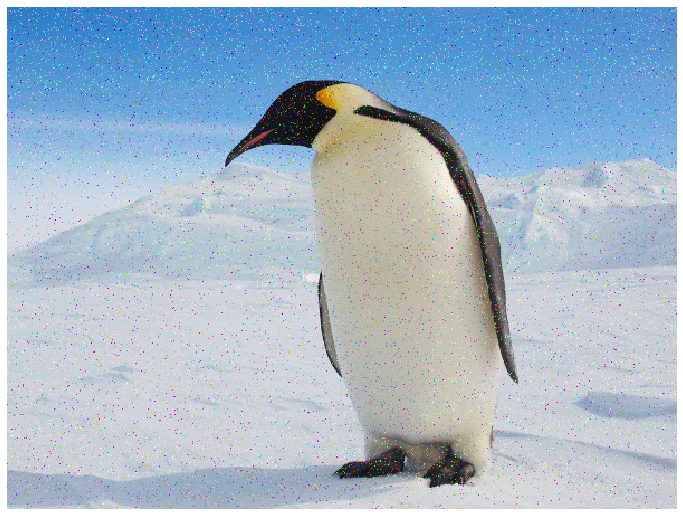

In [55]:
plt.figure(figsize = (12, 12))
plt.axis("off")
plt.imshow(finalImg)
# plt.savefig("img_rcv.png", bbox_inches='tight')

In [56]:
pl = preamble.tolist()

bmpReverse = np.flipud(cv2.cvtColor(finalImg, cv2.COLOR_RGB2BGR))
imgl = bmpReverse.ravel().tolist()

In [57]:
bmpFinal = np.array(pl + imgl, dtype = np.uint8)

In [58]:
with open("forceBmp.bmp", "wb")as f:
    f.write(bmpFinal)

In [59]:
origBit = np.unpackbits(orig[122:])
finalBit = np.unpackbits(bmpFinal[122:])

In [60]:
1 - np.mean(np.equal(origBit, finalBit))

0.024326851851851905